In [69]:
import tensorflow as tf
import matplotlib.pyplot as plt
# Importing layers and models from Keras (which is integrated into TensorFlow)
# 'layers' provides building blocks like Conv2D, MaxPooling2D, Dense, etc.
# 'models' allows us to construct neural network models
from tensorflow.keras import layers, models

# TensorFlow Datasets (tfds) provides ready-to-use datasets, useful for loading standard image datasets
import tensorflow_datasets as tfds

# EarlyStopping callback is used to stop training when the model performance stops improving
# This prevents overfitting and saves time
from tensorflow.keras.callbacks import EarlyStopping

# Sequential is a type of model in Keras where you stack layers one after the other
# It is simple and works well for most straightforward CNN architectures
from tensorflow.keras.models import Sequential
import pickle

In [48]:
# Step 2: Load The Dataset From Tensorflow Datasets

In [49]:
# Load the "cats_vs_dogs" dataset from TensorFlow Datasets (tfds)
# We're splitting the dataset into 80% for training and 20% for validation
# 'with_info=True' gives us additional metadata about the dataset (like labels, number of examples, etc.)
# 'as_supervised=True' returns the data in the form of (image, label) pairs

dataset, info = tfds.load(
'cats_vs_dogs',
split=['train[:80%]', 'train[80%:]'],
with_info=True,
as_supervised=True
)
# Name of the dataset
# 80% training, 20% validation
# Return the dataset info (useful for metadata)
# Return (image, label) instead of a dictionary

In [50]:
# Unpack the dataset splits into training and validation datasets
train_ds, val_ds = dataset

In [51]:
# Step 3: Preprocess the data

In [52]:
# Define a data augmentation pipeline using Keras' Sequential API
# These layers randomly apply transformations to images during training
# This helps the model generalize better by seeing a variety of image distortions
data_augmentation = tf.keras.Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.RandomRotation(0.2),
layers.RandomZoom(0.1),
layers.RandomContrast(0.2)
 ])
# Randomly rotate images by a factor of 0.2 (in radians)
# Randomly zoom images in/out by 10%
# Randomly adjust contrast by 20%

In [53]:
# Define a function to preprocess the dataset images and labels
def preprocess_data(image, label):
    # Resize the image to 128x128 pixels (uniform input size for the model)
    image = tf.image.resize(image, [128, 128])
    # Normalize pixel values by dividing by 255 (puts values between 0 and 1)
    image /= 255.0
    return image, label

def preprocess_train_data(image, label):
    image, label = preprocess_data(image, label)
    # Apply data augmentation to the image (only during training)
    image = data_augmentation(image)
    return image, label

In [54]:
# Step 4 : Prepare Datasets

In [55]:
# Set the batch size (number of samples processed before the model updates)
batch_size = 32
# Prepare the training dataset:
train_ds = (
train_ds
.map(preprocess_train_data)# Apply the preprocess_data function to each (image, label)  pair
.shuffle(1000)      # Shuffle the dataset with a buffer size of 1000 (for randomness)
.batch(batch_size)
.prefetch(buffer_size=tf.data.AUTOTUNE)  # Shuffle the dataset with a buffer size of 1000 (for randomness)
                                        # Group the data into batches of 32 images
                                        # Prefetch data for better performance (non-blocking data loading)
)

In [56]:
# Prepare the validation dataset:
val_ds = (
val_ds
.map(preprocess_data)
# Apply the same preprocessing (without shuffling oraugmentation)
.batch(batch_size)
# Batch the validation data
.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch to speed up validation as well
)

In [57]:
# Step 5 : Build the CNN architecture

In [58]:
# Build a Convolutional Neural Network (CNN) using Keras Sequential API
model = models.Sequential([
# 1st Convolutional Layer:
# Applies 32 filters of size 3x3, uses ReLU activation
# Applies L2 regularization (to reduce overfitting)
# Input shape is 128x128x3 (image size with 3 color channels)
layers.Conv2D(32, (3, 3), activation='relu',
kernel_regularizer=tf.keras.regularizers.l2(0.01),
input_shape=(128, 128, 3)),
# 1st Max Pooling Layer: downsample the feature maps by taking the max in 2x2 regions
layers.MaxPooling2D(pool_size=(2, 2)),
# 2nd Convolutional Layer: 64 filters, no regularization needed here
layers.Conv2D(64, (3, 3), activation='relu'),
# 2nd Max Pooling Layer
layers.MaxPooling2D(pool_size=(2, 2)),
# 3rd Convolutional Layer: 128 filters, more depth to capture complex features
layers.Conv2D(128, (3, 3), activation='relu'),
# 3rd Max Pooling Layer
layers.MaxPooling2D(pool_size=(2, 2)),
# Flatten the output from the convolutional layers to feed into dense (fully connected) layers
layers.Flatten(),
# Dense (fully connected) layer with 128 neurons and ReLU activation
layers.Dense(128, activation='relu'),
# Dropout layer: randomly drops 20% of neurons during training to prevent overfitting
layers.Dropout(0.2),
# Output layer: 1 neuron with sigmoid activation (since it's a binary classification: cat or dog)
layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [59]:
# Compile the model:
# - Optimizer: Adam (adaptive learning rate)
# - Loss: binary_crossentropy (appropriate for binary classification)
# - Metrics: track accuracy during training and evaluation
model.compile(
optimizer='adam',
loss='binary_crossentropy',
metrics=['accuracy']
)

In [60]:
# Step 6 : Define Early Stopping Callback

In [61]:
# # EarlyStopping callback helps stop training when the model performance on the validation set stops improving
# early_stopping = EarlyStopping(
# monitor='val_loss',  # Monitor the validation loss to detect when the model starts overfitting
# patience=3           # Stop training if 'val_loss' does not improve for 3 consecutive epochs
# )

In [62]:
# Step 7 : Train the CNN Model

In [63]:
# Build a Convolutional Neural Network (CNN) using Keras Sequential API
model = models.Sequential([
    # 1st Convolutional Layer:
    # Applies 32 filters of size 3x3, uses ReLU activation
    # Applies L2 regularization (to reduce overfitting)
    # Input shape is 128x128x3 (image size with 3 color channels)
    layers.Conv2D(32, (3, 3), activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.01),
                  input_shape=(128, 128, 3)),
    # 1st Max Pooling Layer: downsample the feature maps by taking the max in 2x2 regions
    layers.MaxPooling2D(pool_size=(2, 2)),
    # 2nd Convolutional Layer: 64 filters, no regularization needed here
    layers.Conv2D(64, (3, 3), activation='relu'),
    # 2nd Max Pooling Layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    # 3rd Convolutional Layer: 128 filters, more depth to capture complex features
    layers.Conv2D(128, (3, 3), activation='relu'),
    # 3rd Max Pooling Layer
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flatten the output from the convolutional layers to feed into dense (fully connected) layers
    layers.Flatten(),
    # Dense (fully connected) layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    # Dropout layer: randomly drops 20% of neurons during training to prevent overfitting
    layers.Dropout(0.2),
    # Output layer: 1 neuron with sigmoid activation (since it's a binary classification: cat or dog)
    layers.Dense(1, activation='sigmoid')
])

# Compile the model:
# - Optimizer: Adam (adaptive learning rate)
# - Loss: binary_crossentropy (appropriate for binary classification)
# - Metrics: track accuracy during training and evaluation
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set the maximum number of training epochs
epochs = 30
# Train the model using the training dataset, and validate on the validation dataset
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)
# Training data
# Validation data to evaluate performance after each epoch
# Maximum number of epochs to train
# Apply early stopping to halt training if val_loss stops improving

Epoch 1/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.5478 - loss: 0.7231 - val_accuracy: 0.6202 - val_loss: 0.6725
Epoch 2/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 665s 1s/step - accuracy: 0.6300 - loss: 0.6588 - val_accuracy: 0.6812 - val_loss: 0.6020
Epoch 3/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 721s 1s/step - accuracy: 0.6737 - loss: 0.6104 - val_accuracy: 0.6814 - val_loss: 0.5991
Epoch 4/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 671s 1s/step - accuracy: 0.6970 - loss: 0.5888 - val_accuracy: 0.7085 - val_loss: 0.5774
Epoch 5/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 704s 1s/step - accuracy: 0.7157 - loss: 0.5646 - val_accuracy: 0.7352 - val_loss: 0.5395
Epoch 6/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - accuracy: 0.7306 - loss: 0.5512 - val_accuracy: 0.7203 - val_loss: 0.5517
Epoch 7/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 707s 1s/step - accuracy: 0.7309 - loss: 0.5478 - val_accuracy: 0.7259 - val_loss: 0.5464
Epoch 8/30
582/582 ━━━━━━━━━━━━━━━━━━━━ 685s 1s/step - accuracy: 0.7353 - loss: 0.5418 - val_accu

In [64]:
# Step 8 : Evaluate The Model

In [65]:

# Evaluate the model's performance on the validation dataset
# This returns the loss and accuracy on unseen validation data
loss, accuracy = model.evaluate(val_ds)
# Print the validation accuracy with 2 decimal places
print(f'Validation Accuracy: {accuracy:.2f}')

146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.7932 - loss: 0.4711
Validation Accuracy: 0.80


In [ ]:
# Step 9 : Plot The Training History

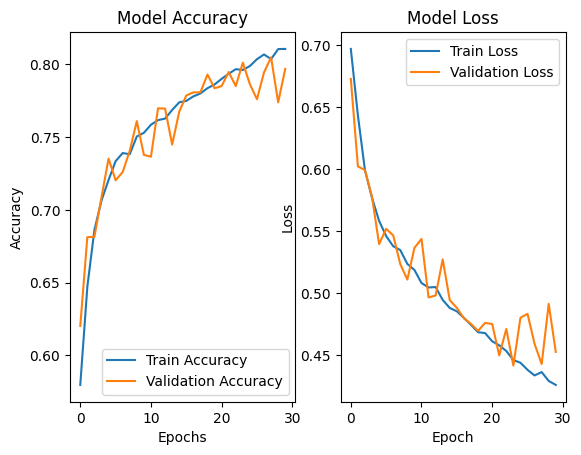

<Figure size 1200x500 with 0 Axes>

In [71]:
# Define a function to plot training and validation accuracy & loss over epochs
def plot_history(history):
    plt.figure(figsize=(12, 5))
# Plot accuracy over epochs
plt.subplot(1, 2, 1)
# Set the figure size for better visibility
# Create the first subplot (1 row, 2 columns, position 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
# Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
# Plot loss over epochs
# Title of the accuracy plot
# Y-axis label
# X-axis label
# Legend position
plt.subplot(1, 2, 2)  # Create the second subplot (1 row, 2 columns, position 2)
plt.plot(history.history['loss'], label='Train Loss')
     # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
# Show the plots
plt.show()
# Call the function to plot the training history
plot_history(history)


In [72]:
# Step 10: Saving the best model

In [74]:
# Save model using pickle
with open("cat_dog_model.pkl", "wb") as f:
  pickle.dump(model, f)